This script implements a permutation importance analysis for features used in a fine-tuned 
ResNet-based model predicting aerosol mixing state index (Chi). The analysis identifies 
the relative contribution of individual features to the model's predictions.

Key steps include:

1. **Data Preprocessing**:
   - Conversion of input features and targets into NumPy arrays for compatibility with 
     scikit-learn-like functions.

2. **Permutation Importance Calculation**:
   - A custom permutation importance function is used to compute the importance of each feature 
     based on its impact on Mean Squared Error (MSE).
   - Repeated random shuffling is performed to estimate the importance scores.

3. **Feature Ranking**:
   - Features are ranked by their importance scores, allowing for the identification of the 
     most influential predictors.

4. **Visualization**:
   - A horizontal bar chart displays the ranked feature importances.
   - Features are grouped into categories (Aerosol, VOC gas, Non-VOC gas, Environment) with 
     distinct colors for improved interpretability.

This analysis aids in understanding the role of various chemical and environmental factors 
in aerosol research, particularly in their influence on aerosol mixing state predictions.

In [5]:
import os

# Get the current working directory
current_path = os.getcwd()

print(f"The current path is: {current_path}")

The current path is: c:\Users\1\Documents\GitHub\code_MEGAPOLI_Foundation_Model\3_Fine_tune_different _data_size


### Load best fine-tuned model

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
import random




features = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Load the datasets
partmc_train_data = pd.read_csv('../PartMC_data/PartMC_train.csv')

megapoli_train_data = pd.read_csv('../MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')
megapoli_test_data = pd.read_csv('../MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv')


X_train = partmc_train_data[features]

# Prepare MEGAPOLI data
X_megapoli_train = megapoli_train_data[features]
y_megapoli_train = megapoli_train_data.iloc[:, 23]

X_megapoli_test = megapoli_test_data[features]
y_megapoli_test = megapoli_test_data.iloc[:, 23]

# Standardize the data
scaler_X = StandardScaler()
X_train2 = scaler_X.fit_transform(X_train)
X_megapoli_train = scaler_X.transform(X_megapoli_train)
X_megapoli_test = scaler_X.transform(X_megapoli_test)

# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)

In [6]:
# Define the ResNet-like block structure
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out + residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Instantiate the ResNet model
input_size = X_megapoli_train_tensor.shape[1]
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size)

model.load_state_dict(torch.load('../Model/best_resnet_model_finetuned_50%.pth'))

C:\Users\1\AppData\Local\Temp\ipykernel_5400\562166980.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Model/best_resnet_model_fine

<All keys matched successfully>

In [ ]:
# Define a prediction function that works with scikit-learn
def predict_fn(X):
    """
    Generates predictions using the trained model.

    Args:
        X (numpy.ndarray): Input data.
    
    Returns:
        numpy.ndarray: Predicted values.
    """
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_pred = model(X_tensor).view(-1)
        return y_pred.numpy()

# Convert the training tensors to numpy arrays
X_megapoli_train_np = X_megapoli_test_tensor.numpy()
y_megapoli_train_np = y_megapoli_test_tensor.numpy()


# Custom permutation importance function
def permutation_importance_custom(predict_fn, X, y, n_repeats, random_state=None):
    """
    Computes permutation importance for features.

    Args:
        predict_fn (function): Prediction function for the model.
        X (numpy.ndarray): Input feature data.
        y (numpy.ndarray): Target values.
        n_repeats (int): Number of shuffling repeats.
        random_state (int, optional): Random seed for reproducibility.
    
    Returns:
        numpy.ndarray: Importance scores for each feature.
    """
    rng = np.random.RandomState(random_state)
    baseline_preds = predict_fn(X)
    baseline_error = np.mean((baseline_preds - y) ** 2)

    importances = np.zeros(X.shape[1])
    for col in range(X.shape[1]):
        permuted_errors = np.zeros(n_repeats)
        for n in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, col] = rng.permutation(X_permuted[:, col])
            permuted_preds = predict_fn(X_permuted)
            permuted_error = np.mean((permuted_preds - y) ** 2)
            permuted_errors[n] = permuted_error - baseline_error
        importances[col] = np.mean(permuted_errors)
    
    return importances

# Compute permutation importance
importances = permutation_importance_custom(predict_fn, X_megapoli_train_np, y_megapoli_train_np, n_repeats=50, random_state=42)


# Feature names
feature_names = np.array(features)  
# Rank features by importance
feature_indices = np.argsort(importances)[::-1]
ranked_importances = importances[feature_indices]
ranked_feature_names = feature_names[feature_indices]


# Print the ranked features and their importances
for idx in feature_indices:
    print(f"Feature {feature_names[idx]}: Importance {importances[idx]}")

Feature OA (ug/m3): Importance 0.007952234339900315
Feature NOx (ppb): Importance 0.0010807391116395592
Feature RH: Importance 0.0010045142308808862
Feature NH4 (ug/m3): Importance 0.0009442702180240303
Feature CO (ppb): Importance 0.0008736487245187164
Feature NO3 (ug/m3): Importance 0.0008533316757529974
Feature NO (ppb): Importance 0.0007280766207259148
Feature BC (ug/m3): Importance 0.0006031664542388171
Feature SO4 (ug/m3): Importance 0.0006013943278230727
Feature TOL(ppb): Importance 0.00023783006006851791
Feature ALD2 (ppb): Importance 0.00017088408698327838
Feature ETH (ppb): Importance 0.00011659589014016091
Feature XYL (ppb): Importance 9.489493444561959e-05
Feature O3 (ppb): Importance 3.676230320706964e-05
Feature Temperature(K): Importance 2.135996357537806e-05
Feature AONE (ppb): Importance -3.294388297945261e-06
Feature OLET (ppb): Importance -1.2395316734910012e-05
Feature PAR (ppb): Importance -3.177354927174747e-05


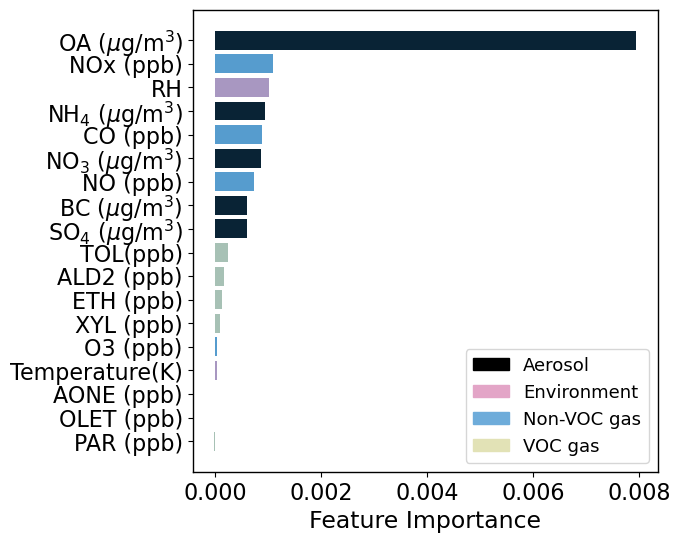

In [ ]:
# Define feature categories and colors
feature_categories = {
    'Aerosol': ['BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)'],  
    'VOC gas': ['ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)', 'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)',],      
    'Non-VOC gas': ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)'],      
    'Environment': ['Temperature(K)', 'RH']  
}

category_colors = {
    'Aerosol': 'black',
    'Environment': '#E3A5C7',
    'Non-VOC gas': '#6EACDA',
    'VOC gas': '#E2E2B6'
}



# Map feature names for display
unit_mapping = {
    'BC (ug/m3)': 'BC ($\mu$g/m$^3$)',
    'OA (ug/m3)': 'OA ($\mu$g/m$^3$)',
    'NH4 (ug/m3)': 'NH$_4$ ($\mu$g/m$^3$)',
    'NO3 (ug/m3)': 'NO$_3$ ($\mu$g/m$^3$)',
    'SO4 (ug/m3)': 'SO$_4$ ($\mu$g/m$^3$)'
}

display_feature_names = [unit_mapping.get(feature, feature) for feature in ranked_feature_names]

fig, ax = plt.subplots(figsize=(6, 6)) 
plt.barh(range(len(ranked_importances)), ranked_importances, align='center')
plt.yticks(range(len(ranked_importances)), display_feature_names)
plt.xlabel('Importance')
plt.gca().invert_yaxis()

# Assign colors to each feature
colors = []
for feature in ranked_feature_names:
    for category, features in feature_categories.items():
        if feature in features:
            colors.append(category_colors[category])
            break
    else:
        colors.append('gray')  # Default color if the feature is not in any category

# Plot the bar chart with colors
bars = plt.barh(range(len(ranked_importances)), ranked_importances, align='center', color=colors, alpha=0.7)

plt.tick_params(axis='x', labelsize=16)

ax.set_yticklabels(display_feature_names, fontsize=16)
ax.set_xlabel('Feature Importance', fontsize=17)

# Add legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
ax.legend(handles=legend_patches, loc='best', fontsize=13)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
plt.savefig('Permutation.png', dpi=400, bbox_inches='tight')

plt.show()